# Falkon Regression Tutorial

## Introduction

This notebook introduces the main interface of the Falkon library, 
using a toy regression problem.

We will be using the Boston housing dataset which is included in `scikit-learn` to train a Falkon model.
Since the dataset is very small, it is not necessary to use the Nystroem approximation here. It is however useful to demonstrate the simple API offered by Falkon.

In [1]:
%matplotlib inline
from sklearn import datasets
import numpy as np
import torch
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import falkon

[pyKeOps]: cuInit failed with error code 100: no CUDA-capable device is detected


## Load the data

The Boston housing dataset poses a regression problem with 506 data points in 13 dimensions.
The goal is to predict house prices given some attributes including criminality rates, air pollution, property value, etc.

After loading the data, we split it into two parts: a training set (containing 80% of the points) and a test 
set with the remaining 20%. Data splitting could alternatively be done using some scikit-learn utilities (found in the [model_selection module](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation))

In [2]:
X, Y = datasets.load_boston(return_X_y=True)

In [3]:
num_train = int(X.shape[0] * 0.8)
num_test = X.shape[0] - num_train
shuffle_idx = np.arange(X.shape[0])
np.random.shuffle(shuffle_idx)
train_idx = shuffle_idx[:num_train]
test_idx = shuffle_idx[num_train:]

Xtrain, Ytrain = X[train_idx], Y[train_idx]
Xtest, Ytest = X[test_idx], Y[test_idx]

## Pre-process the data

We must convert the numpy arrays to PyTorch tensors before using them in Falkon.
This is very easy and fast with the `torch.from_numpy` function.

Another preprocessing step which is often necessary with kernel methods is to normalize the z-score of the data:
convert it to have zero-mean and unit standard deviation.
We use the statistics of the training data to avoid leakage between the two sets.

In [4]:
# convert numpy -> pytorch
Xtrain = torch.from_numpy(Xtrain)
Xtest = torch.from_numpy(Xtest)
Ytrain = torch.from_numpy(Ytrain)
Ytest = torch.from_numpy(Ytest)

In [5]:
# z-score normalization
train_mean = Xtrain.mean(0, keepdim=True)
train_std = Xtrain.std(0, keepdim=True)
Xtrain -= train_mean
Xtrain /= train_std
Xtest -= train_mean
Xtest /= train_std

## Create the Falkon model

The Falkon object is the main API of this library. 
It is similar in spirit to the fit-transform API of scikit-learn, while supporting some
additional features such as monitoring of validation error.

While Falkon models have many options, most are related to performance fine-tuning which becomes useful with much 
larger datasets.
Here we only showcase some of the more basic options.

Mandatory parameters are:
 - the kernel function (here we use a linear kernel)
 - the amount of regularization, which we set to some small positive value
 - the number of inducing points M. 
   Since the dataset is already very small, we use set `M=N` (every data-point is an inducing point). 

In [6]:
options = falkon.FalkonOptions()
kernel = falkon.kernels.GaussianKernel(sigma=5)
flk = falkon.Falkon(kernel=kernel, penalty=1e-5, M=Xtrain.shape[0], options=options)

/home/giacomo/Dropbox/unige/falkon/falkon/falkon/utils/switches.py:25: UserWarning: Failed to initialize CUDA library; falling back to CPU. Set 'use_cpu' to True to avoid this warning.
  warnings.warn(get_error_str("CUDA", None))


## Training the model

The Falkon model is trained using the preconditioned conjugate gradient algorithm (TODO: Add a reference). Thus there are
two steps to the algorithm: first the preconditioner is computed, and then the conjugate gradient iterations are performed.
To gain more insight in the various steps of the algorithm you can pass `debug=True` when creating the Falkon object. 

Model training will occur on the GPU, if it is available, and CUDA is properly installed, 
or on the CPU as a fallback. 

If KeOps has been installed alongside Falkon, the first run may take
a bit longer due to the compilation step of KeOps (to avoid using KeOps you can pass the argument `keops_active=False` to the `FalkonOptions` object).

In [7]:
flk.fit(Xtrain, Ytrain)

Stopping conjugate gradient descent at iteration 1. Solution has converged.


Falkon(M=404, center_selection=<falkon.center_selection.UniformSelector object at 0x7f31c8279190>, error_every=1, error_fn=None, kernel=GaussianKernel(sigma=tensor([5.], dtype=torch.float64)), maxiter=20, options=FalkonOptions(keops_acc_dtype='auto', keops_sum_scheme='auto', keops_active='auto', chol_force_in_core=False, chol_force_ooc=False, chol_par_blk_multiplier=2, lauum_par_blk_multiplier=8, pc_epsilon_32=1e-05, pc_epsilon_64=1e-13, cpu_preconditioner=False, cg_epsilon_32=1e-07, cg_epsilon_64=1e-15, cg_tolerance=1e-07, cg_full_gradient_every=10, debug=False, use_cpu=False, max_gpu_mem=inf, max_cpu_mem=inf, compute_arch_speed=False, no_single_kernel=True, min_cuda_pc_size_32=10000, min_cuda_pc_size_64=30000, min_cuda_iter_size_32=300000000, min_cuda_iter_size_64=900000000, never_store_kernel=False, num_fmm_streams=2), penalty=1e-05, seed=None, weight_fn=None)

Optimization converges very quickly to a minimum, where convergence is detected by checking the change model parameters between iterations.

## Evaluating model performance

Since the problem is regression a natural error metric is the RMSE. Given a fitted model, we can run the `predict` method to obtain predictions on new data.

Here we print the error on both train and test sets.

In [8]:
train_pred = flk.predict(Xtrain).reshape(-1, )
test_pred = flk.predict(Xtest).reshape(-1, )

def rmse(true, pred):
    return torch.sqrt(torch.mean((true.reshape(-1, 1) - pred.reshape(-1, 1))**2))

print("Training RMSE: %.3f" % (rmse(train_pred, Ytrain)))
print("Test RMSE: %.3f" % (rmse(test_pred, Ytest)))

Training RMSE: 1.794
Test RMSE: 3.534


Finally we plot the model predictions to check that the distribution of our predictions is close to that of the labels.

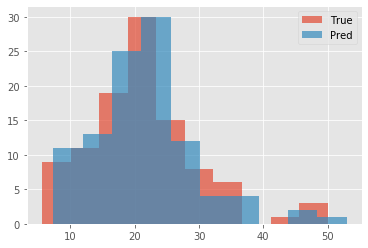

In [9]:
fig, ax = plt.subplots()
ax.hist(Ytest, alpha=0.7, label="True")
ax.hist(test_pred, alpha=0.7, label="Pred")
ax.legend(loc="best")